In [10]:
# This notebook is from this example: http://karlrosaen.com/ml/notebooks/em-coin-flips/
# (with some extra comments added)
# Please refer to that page for a detailed explanation of the setup of the problem we're solving.

import numpy as np
import random

In [14]:
def coin_em(rolls, theta_A=None, theta_B=None, maxiter=10):
    # Initial Guess
    theta_A = theta_A or random.random()
    theta_B = theta_B or random.random()
    thetas = [(theta_A, theta_B)]
    for c in range(maxiter):
        print("#%d:\t%0.2f %0.2f" % (c, theta_A, theta_B))
        # The expected number of heads and tails observed by each coin:
        heads_A, tails_A, heads_B, tails_B = e_step(rolls, theta_A, theta_B)
        # The updated coin biases (ie probability of seeing heads) for each coin:
        theta_A, theta_B = m_step(heads_A, tails_A, heads_B, tails_B)
        
    thetas.append((theta_A,theta_B))    
    return thetas, (theta_A,theta_B)

def e_step(rolls, theta_A, theta_B):
    """Produce the expected value for heads_A, tails_A, heads_B, tails_B 
    over the rolls given the coin biases"""
    
    heads_A, tails_A = 0,0
    heads_B, tails_B = 0,0
    for trial in rolls:
        # likelihood_A is p(coin sequence | Z = A) which is Binomial
        likelihood_A = coin_likelihood(trial, theta_A)  
        likelihood_B = coin_likelihood(trial, theta_B)
        # p_A is p(Z = A | coin sequence) - analogously for p_B
        p_A = likelihood_A / (likelihood_A + likelihood_B)
        p_B = likelihood_B / (likelihood_A + likelihood_B)
        # The expected number of heads and tails observed by each coin:
        heads_A += p_A * trial.count("H")
        tails_A += p_A * trial.count("T")
        heads_B += p_B * trial.count("H")
        tails_B += p_B * trial.count("T") 
    return heads_A, tails_A, heads_B, tails_B

def m_step(heads_A, tails_A, heads_B, tails_B):
    """Produce the values for theta that maximize the expected number of heads/tails"""

    theta_A = heads_A / (heads_A + tails_A)
    theta_B = heads_B / (heads_B + tails_B)
    return theta_A, theta_B

def coin_likelihood(roll, bias):
    # P(X | Z, theta)
    numHeads = roll.count("H")
    flips = len(roll)
    return pow(bias, numHeads) * pow(1-bias, flips-numHeads)

In [20]:
rolls = [ "HTTTHHTHTH", 
         "HHHHTHHHHH", 
         "HTHHHHHTHH", 
         "HTHTTTHHTT", 
         "THHHTHHHTH" ]
thetas, _ = coin_em(rolls, 0.6, 0.5, maxiter=6)
print("thetas {}".format(thetas))

#0:	0.60 0.50
#1:	0.71 0.58
#2:	0.75 0.57
#3:	0.77 0.55
#4:	0.78 0.53
#5:	0.79 0.53
thetas [(0.6, 0.5), (0.7945325379936994, 0.5223904375178747)]


In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl


def plot_coin_likelihood(rolls, thetas=None):
    # grid
    xvals = np.linspace(0.01,0.99,100)
    yvals = np.linspace(0.01,0.99,100)
    X,Y = np.meshgrid(xvals, yvals)
    
    # compute likelihood
    Z = []
    for i,r in enumerate(X):  # r goes over values for \theta_A
        z = []
        for j,c in enumerate(r):  # c goes over values for \theta_B
            z.append(coin_marginal_likelihood(rolls,c,Y[i][j]))
        Z.append(z)
    
    # plot
    plt.figure(figsize=(10,8))
    C = plt.contour(X,Y,Z,150)
    cbar = plt.colorbar(C)
    plt.title(r"Likelihood $\log p(\mathcal{X}|\theta_A,\theta_B)$", fontsize=20)
    plt.xlabel(r"$\theta_A$", fontsize=20)
    plt.ylabel(r"$\theta_B$", fontsize=20)
    
    # plot initial and final values of theta
    # so we can confirm that the final ones lie on (or close to)
    # the minimum of the contour plot
    if thetas is not None:
        thetas = np.array(thetas)
        plt.plot(thetas[:,0], thetas[:,1], '-k', lw=2.0)  # initial values
        plt.plot(thetas[:,0], thetas[:,1], 'ok', ms=5.0)  # final values
        

def coin_marginal_likelihood(rolls, biasA, biasB):
    """ 
    What's being computed here is log p(E | \theta_A, \theta_B)
    In order to compute this quantity we need to marginalize out the latent
    variable, i.e. the identity of each die (Z)
    
    So we have:
    log p(E | \theta_A, \theta_B) = log \sum_{Z}( p(E, Z | \theta_A, \theta_B) ) = 
    log \sum_{Z} ( p(Z)p(E | Z, \theta_A, \theta_B) ) = 
    log( p(Z = A)p(E | \theta_A) + p(Z = B)p(E | \theta_B) )
    
    where p(Z = A) = p( Z = B ) = 0.5 (we assumed uniform prior over which die is chosen)
    and p(E | \theta_A) is the likelihood of seeing the roll E by the die A (Bernoulli)
    
    So     log p(E | \theta_A, \theta_B) = log 0.5(likelihood_A + likelihood_B)
    
    (where E are the rolls)
    """
    trials = []
    for roll in rolls:
        h = roll.count("H")
        t = roll.count("T")
        likelihoodA = coin_likelihood(roll, biasA)  # p(E | Z = A)
        likelihoodB = coin_likelihood(roll, biasB) # p(E | Z = B)
        trials.append(np.log(0.5 * (likelihoodA + likelihoodB)))
    return sum(trials)

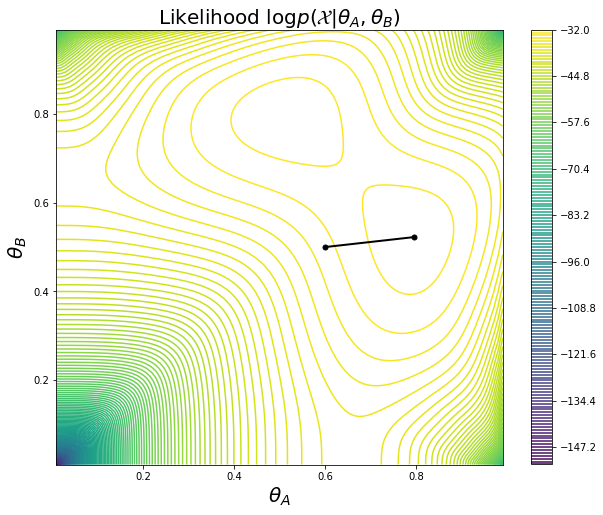

In [24]:
plot_coin_likelihood(rolls, thetas)